# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [1]:
arms = 3
turns = 1.5
width = 0.3
noise = .5
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


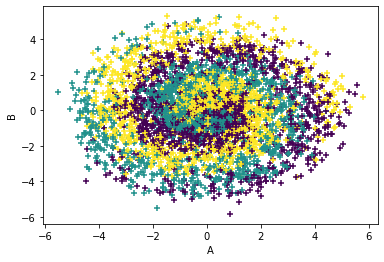

In [2]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [5]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[197  32  37]
 [ 42 200  25]
 [ 20  39 208]]
Accuracy is   0.75625
Precision is  0.7563264796161475
Recall is     0.75625
F1 is         0.7562220833073734


### Train and evaluate SVC model 

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[799 138 130]
 [180 749 137]
 [150 130 786]]
Accuracy is   0.7296030009377931
Precision is  0.7302011403746573
Recall is     0.7296030009377931
F1 is         0.7295664573871311

Results for svc on test data
  Default settings
Confusion Matrix
[[197  36  33]
 [ 46 189  32]
 [ 50  25 192]]
Accuracy is   0.7225
Precision is  0.7252115418785939
Recall is     0.7225
F1 is         0.7229545207579001


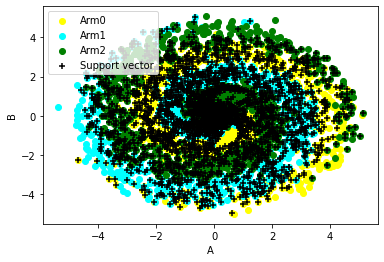

In [8]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[886 117  64]
 [ 84 898  84]
 [ 70  90 906]]
Accuracy is   0.8408877774304471
Precision is  0.8413950596880895
Recall is     0.8408877774304471
F1 is         0.8409972330895995

Results for NN on test data
  Default settings
Confusion Matrix
[[212  28  26]
 [ 22 231  14]
 [ 24  28 215]]
Accuracy is   0.8225
Precision is  0.8232421618675833
Recall is     0.8225
F1 is         0.822299774720626


/opt/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Train and evaluate ADA boosted model

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)

y_pred = ada_model.predict(X)


print('Results for ADA on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))

Results for ADA on train data
  Default settings
Confusion Matrix
[[694 202 171]
 [170 732 164]
 [176 186 704]]
Accuracy is   0.665833072835261
Precision is  0.6661515987824873
Recall is     0.665833072835261
F1 is         0.6657833071781158

Results for ADA on test data
  Default settings
Confusion Matrix
[[164  51  51]
 [ 49 184  34]
 [ 43  47 177]]
Accuracy is   0.65625
Precision is  0.6562460981910833
Recall is     0.65625
F1 is         0.6559842598895372


### Train and evaluate Random Forest model

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X,y)

y_pred = rf_model.predict(X)


print('Results for Random Forest on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)
print('Results for Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))

Results for Random Forest on train data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data
  Default settings
Confusion Matrix
[[146  61  59]
 [ 47 161  59]
 [ 61  53 153]]
Accuracy is   0.575
Precision is  0.5749446235607667
Recall is     0.575
F1 is         0.5748191256712396


### Train and evaluate Voting model
We build it out of three different kinds of classifiers.
One each of DT, SVC and NN

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

# Build the classifiers
vc1_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                       solver='lbfgs')
# Bundle into a list with names
vcList = [('DT', vc1_dt),
        ('SVM', vc2_svm),
        ('NN', vc3_nn)]

vc_model = VotingClassifier(vcList)

vc_model.fit(X,y)


y_pred = vc_model.predict(X)
print('Results for Voting Ensemble on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = vc_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))

/opt/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on train data
  Default settings
Confusion Matrix
[[912  79  76]
 [ 42 964  60]
 [ 73  48 945]]
Accuracy is   0.8818380743982495
Precision is  0.8819375587524884
Recall is     0.8818380743982495
F1 is         0.8817274280717131

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[198  31  37]
 [ 22 222  23]
 [ 32  30 205]]
Accuracy is   0.78125
Precision is  0.7812449163277552
Recall is     0.78125
F1 is         0.7808298077811235


### Cross Validate a Decision Tree model

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for train_indices, validate_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]
    
    X = train_set[['A', 'B' ]]
    y = train_set['Class']
    
    X_validate = validate_set[['A', 'B']]
    y_validate = validate_set['Class']
    
    model = DecisionTreeClassifier()
    model.fit(X,y)
    y_validate_pred = model.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_validate_pred)
    print('Confusion Matrix')
    print(confusion_matrix(y_validate, y_validate_pred))
    print('Accuracy is ', accuracy)

    accuracy_list = np.insert(accuracy_list, 0, accuracy)
    

Confusion Matrix
[[102  14  18]
 [ 13 104  16]
 [ 19  13 101]]
Accuracy is  0.7675
Confusion Matrix
[[ 97  29   8]
 [ 17 105  11]
 [ 17  19  97]]
Accuracy is  0.7475
Confusion Matrix
[[108  14  12]
 [ 17  98  18]
 [  9  10 114]]
Accuracy is  0.8
Confusion Matrix
[[ 97  17  19]
 [ 20 102  12]
 [ 20  15  98]]
Accuracy is  0.7425
Confusion Matrix
[[ 99  20  14]
 [ 15 103  16]
 [  6  18 109]]
Accuracy is  0.7775
Confusion Matrix
[[104  12  17]
 [ 20  98  16]
 [ 16  14 103]]
Accuracy is  0.7625
Confusion Matrix
[[ 98  21  14]
 [ 18  94  21]
 [ 17  17 100]]
Accuracy is  0.73
Confusion Matrix
[[ 99  19  15]
 [ 14 104  15]
 [ 10  13 111]]
Accuracy is  0.785
Confusion Matrix
[[102  11  20]
 [ 22  89  22]
 [ 20  16  98]]
Accuracy is  0.7225
Confusion Matrix
[[102  12  19]
 [ 16 101  16]
 [ 13  18 102]]
Accuracy is  0.7644110275689223


In [27]:
print('Accuracy values', accuracy_list)
print('   Average of ', np.average(accuracy_list))
print('   StDev of ', np.std(accuracy_list))

Accuracy values [0.76441103 0.7225     0.785      0.73       0.7625     0.7775
 0.7425     0.8        0.7475     0.7675    ]
   Average of  0.7599411027568923
   StDev of  0.023198970829244422


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B, 150 Estimators|66.58|66.58|65.63|65.60|
|Random Forest|A,B, 150 Estimators|100.0|100.0|78.5|78.5|
|Voting Ensemble|A,B layers (50,25,10)|88.18|88.18|78.12|78.08|